<div class="notebook-buttons" style="display:flex; padding-top: 5rem;padding-bottom: 2.5rem;line-height: 2.15;">
    <a href="https://colab.research.google.com/github/zazuko/notebooks/blob/master/notebooks/animal-disease/epidemics.ipynb">
        <div id="colab-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; align-items: center;">
            <img class="call-to-action-img" src="img//colab.svg" width="30" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Run in Google Colab</div>
        </div>
    </a>
    <a href="https://raw.githubusercontent.com/zazuko/notebooks/master/notebooks/animal-disease/epidemics.ipynb" download>
        <div id="download-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img//download.svg" width="22" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Download Notebook</div>
        </div>
    </a>
    <a href="https://github.com/zazuko/notebooks/blob/master/notebooks/animal-disease/epidemics.ipynb">
        <div id="github-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img//github.svg" width="25" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">View on GitHub</div>
        </div>
    </a>
</div>

# Animal epidemics in Switzerland

FOAG, Federal Office for Agriculture, collects data on the animal diseases in Switzerland. This data is published as [Linked Data](https://en.wikipedia.org/wiki/Linked_data). 

In this tutorial, we will show **how to work with Linked Data.** Mainly, we will see how to work with data on animal epidemics.   
We will look into how to query, process, and visualize it.   

## Ideas

* Animal hierarchy
* Disease hierarchy
* Number of reports per gde, over time (https://python-visualization.github.io/folium/plugins.html#folium.plugins.TimeSliderChoropleth)

* Serious outbreaks: find reports where stock == killed

In [1]:
import json

import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from graphly.api_client import SparqlClient

In [2]:
sparql = SparqlClient("https://int.lindas.admin.ch/query")
geosparql = SparqlClient("https://ld.geo.admin.ch/query")

sparql.add_prefixes({
    "schema": "<http://schema.org/>",
    "cube": "<https://cube.link/>",
    "admin": "<https://schema.ld.admin.ch/>",
    "skos": "<http://www.w3.org/2004/02/skos/core#>",
    "disease": "<https://environment.ld.admin.ch/foen/animal-pest/>"   
})

geosparql.add_prefixes({
    "dct": "<http://purl.org/dc/terms/>",
    "geonames": "<http://www.geonames.org/ontology#>",
    "schema": "<http://schema.org/>",
    "geosparql": "<http://www.opengis.net/ont/geosparql#>",
})

### Animals hierarchy

In [47]:
query = """
SELECT DISTINCT ?specie ?group
WHERE {
  ?s disease:animal-specie ?specieIRI.
  ?specieIRI schema:name ?specie.
  
  ?specieIRI skos:broader/schema:name ?group.
  
  FILTER (LANG(?specie) = "de")
  FILTER (LANG(?group) = "de")
} 
ORDER BY ?group
"""

df = sparql.send_query(query)
df.head()

,specie,group
0,Anderes Haustier,Andere Haustiere
1,Bienen,Bienen
2,Pferd,Equiden
3,Fisch,Fische
4,Krebs,Fische


## Disease hierarchy

In [48]:
query = """
SELECT DISTINCT ?epidemics ?group
WHERE {
  ?s disease:epidemics ?epidemicsIRI.
  ?epidemicsIRI schema:name ?epidemics.
  
  ?epidemicsIRI skos:broader/schema:name ?group.

  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?group) = "de")
}
ORDER BY ?group
"""

df = sparql.send_query(query)
df.head()

,epidemics,group
0,Bovine Virusdiarrhoe / Mucosal Disease,Auszurottende Seuchen
1,Brucellose der Rinder,Auszurottende Seuchen
2,Tollwut,Auszurottende Seuchen
3,Infektiöse Agalaktie,Auszurottende Seuchen
4,Bovine spongiforme Enzephalopathie,Auszurottende Seuchen


## Can we link disease to animal type?

In [21]:
query = """
SELECT DISTINCT ?epidemics ?specie ?group
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:animal-specie ?specieIRI.
       
  ?specieIRI schema:name ?specie.
  ?specieIRI skos:broader/schema:name ?group.
  
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?specie) = "de")
  FILTER (LANG(?group) = "de")
} 

ORDER BY ?specie
"""

df = sparql.send_query(query)
df.head()

,epidemics,specie,group
0,Tuberkulose / Mykobacteriose,Affe,Wildtier
1,Toxoplasmose,Affe,Wildtier
2,Campylobacteriose,Affe,Wildtier
3,Salmonellose,Affe,Wildtier
4,Listeriose,Affe,Wildtier


In [25]:
import networkx as nx

g = nx.Graph()
g.add_nodes_from(df.specie, type="animal")
#g.add_nodes_from(df.group, type="group")
g.add_nodes_from(df.epidemics, type="epidemics")

g.add_edges_from(zip(df.epidemics, df.specie))
#g.add_edges_from(zip(df.specie, df.group))


In [26]:
attributes = nx.get_node_attributes(g, "type")
mapping = {
    "animal": "lightblue",
    "group": "blue",
    "epidemics": "orange"
}
colors = [mapping[attribute] for attribute in attributes.values()]
attributes

{'Affe': 'animal',
 'Anderer Hausvogel': 'animal',
 'Anderer Wildvogel': 'animal',
 'Anderes Haustier': 'animal',
 'Anderes Wildtier': 'animal',
 'Anderes Zootier': 'animal',
 'Bienen': 'animal',
 'Dachs': 'animal',
 'Echse': 'animal',
 'Fisch': 'animal',
 'Fledermaus': 'animal',
 'Fuchs': 'animal',
 'Greifvogel': 'animal',
 'Gämse': 'animal',
 'Hase': 'animal',
 'Hausente': 'animal',
 'Hausgans': 'animal',
 'Hirsch': 'animal',
 'Huhn': 'animal',
 'Hund': 'animal',
 'Igel': 'animal',
 'Kaninchen': 'animal',
 'Katze': 'animal',
 'Krebs': 'animal',
 'Känguru': 'animal',
 'Luchs': 'animal',
 'Marder': 'animal',
 'Maus': 'animal',
 'Papagei': 'animal',
 'Pfau': 'animal',
 'Pferd': 'animal',
 'Reh': 'animal',
 'Rind': 'animal',
 'Schaf': 'animal',
 'Schildkröte': 'animal',
 'Schlange': 'animal',
 'Schwein': 'animal',
 'Singvogel': 'animal',
 'Sittich': 'animal',
 'Taube': 'animal',
 'Wachtel': 'animal',
 'Wildschwein': 'animal',
 'Wolf': 'animal',
 'Ziege': 'animal',
 'Tuberkulose / Mykobac

In [12]:
import networkx as nx

from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx, figure

# Prepare Data
#G = nx.karate_club_graph()

#SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
#edge_attrs = {}
#
#for start_node, end_node, _ in G.edges(data=True):
#    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
#    edge_attrs[(start_node, end_node)] = edge_color

#nx.set_edge_attributes(G, edge_attrs, "edge_color")

# Show with Bokeh
#plot = Plot(plot_width=400, plot_height=400,
#            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))


#plot.title.text = "Graph Interaction Demonstration"

plot = figure(title="Networkx Integration Demonstration",
              tools="", toolbar_location=None)

node_hover_tool = HoverTool(tooltips=[("index", "@index")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(g, nx.circular_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)


#graph = from_networkx(g, nx.circular_layout, scale=1, center=(0,0))
#graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')
#graph.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
#graph.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])
#
#graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=1)
#graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=3)
#graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=3)



graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

output_file("interactive_graphs.html")
show(plot)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_color" value "edge_color" [renderer: GlyphRenderer(id='1128', ...)]


In [34]:
src = ColumnDataSource(df)

print(graph_renderer.node_renderer.data_source.data)

{'index': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 17

In [28]:
import networkx as nx

from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx, ColumnDataSource

from bokeh.models import (Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,)
from bokeh.palettes import Spectral4


# Show with Bokeh
plot = Plot()
plot.title.text = "Graph Interaction Demonstration"

#plot = figure(title="Networkx Integration Demonstration",
#              tools="", toolbar_location=None)

hoverTool = HoverTool(tooltips=[("type", "@type")])
plot.add_tools(hoverTool, TapTool())

#src = ColumnDataSource(df)

graph = from_networkx(g, nx.circular_layout, scale=1, center=(0,0))
graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')
graph.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])
#graph_renderer.node_renderer.data_source.data = attributes

graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=1)
graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=3)
graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=3)

graph.selection_policy = NodesAndLinkedEdges()
graph.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph)

output_file("networkx_graph.html")
show(plot)


ValueError: failed to validate ColumnDataSource(id='1914', ...).data: expected an element of ColumnData(String, Seq(Any)), got {'index': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259]), 'epidemics': array(['Campylobacteriose', 'Echinokokkose', 'Listeriose', 'Tularämie',
       'Coxiellose', 'Toxoplasmose', 'Salmonellose', 'Yersiniose',
       'Tuberkulose / Mykobacteriose',
       'Salmonella-Infektion des Geflügels', 'Campylobacteriose',
       'Chlamydiose der Vögel', 'Infektiöse Laryngotracheitis der Hühner',
       'Newcastle Krankheit', 'Salmonellose',
       'Infektiöse Laryngotracheitis der Hühner', 'Listeriose',
       'Geflügelpest (Aviäre Influenza)', 'Campylobacteriose',
       'Chlamydiose der Vögel', 'Salmonellose', 'Yersiniose',
       'Bovine Virusdiarrhoe / Mucosal Disease', 'Listeriose',
       'Leptospirose', 'Yersiniose', 'Echinokokkose', 'Campylobacteriose',
       'Coxiellose', 'Kryptosporidiose', 'Toxoplasmose',
       'Pseudotuberkulose der Schafe und Ziegen', 'Salmonellose',
       'Bösartiges Katarrhalfieber', 'Paratuberkulose', 'Trichinellose',
       'Krebspest', 'Toxoplasmose', 'Coxiellose', 'Campylobacteriose',
       'Echinokokkose', 'Yersiniose', 'Kryptosporidiose', 'Salmonellose',
       'Leptospirose', 'Echinokokkose', 'Kryptosporidiose',
       'Leptospirose', 'Campylobacteriose', 'Salmonellose',
       'Toxoplasmose', 'Yersiniose', 'Tuberkulose / Mykobacteriose',
       'Varroa jacobsoni (Milbenkrankheit der Bienen)',
       'Faulbrut der Bienen', 'Sauerbrut der Bienen', 'Tollwut',
       'Salmonellose', 'Kryptosporidiose',
       'Proliferative Nierenkrankheit der Fische',
       'Frühlingsvirämie der Karpfen', 'Infektiöse Pankreasnekrose',
       'Infektiöse Hämatopoietische Nekrose',
       'Virale hämorrhagische Septikämie', 'Tollwut', 'Listeriose',
       'Trichinellose', 'Echinokokkose', 'Tollwut', 'Toxoplasmose',
       'Salmonellose', 'Geflügelpest (Aviäre Influenza)', 'Salmonellose',
       'Campylobacteriose', 'Kryptosporidiose', 'Yersiniose',
       'Virale hämorrhagische Krankheit der Kaninchen',
       'Brucellose der Schweine', 'Tularämie', 'Echinokokkose',
       'Salmonellose', 'Geflügelpest (Aviäre Influenza)', 'Salmonellose',
       'Campylobacteriose', 'Campylobacteriose', 'Salmonellose',
       'Listeriose', 'Paratuberkulose', 'Bösartiges Katarrhalfieber',
       'Yersiniose', 'Kryptosporidiose', 'Neosporose', 'Salmonellose',
       'Campylobacteriose', 'Pseudotuberkulose der Schafe und Ziegen',
       'Tuberkulose / Mykobacteriose', 'Listeriose', 'Campylobacteriose',
       'Infektiöse Laryngotracheitis der Hühner', 'Toxoplasmose',
       'Salmonellose', 'Salmonella-Infektion des Geflügels',
       'Newcastle Krankheit', 'Echinokokkose', 'Tollwut', 'Toxoplasmose',
       'Kryptosporidiose', 'Campylobacteriose', 'Leptospirose',
       'Tuberkulose / Mykobacteriose', 'Yersiniose', 'Salmonellose',
       'Salmonellose', 'Yersiniose', 'Myxomatose', 'Yersiniose',
       'Campylobacteriose',
       'Virale hämorrhagische Krankheit der Kaninchen', 'Salmonellose',
       'Listeriose', 'Tuberkulose / Mykobacteriose', 'Salmonellose',
       'Campylobacteriose', 'Tollwut', 'Toxoplasmose',
       'Chlamydiose der Vögel', 'Listeriose', 'Tularämie',
       'Kryptosporidiose', 'Yersiniose', 'Krebspest', 'Campylobacteriose',
       'Toxoplasmose', 'Kryptosporidiose', 'Salmonellose', 'Toxoplasmose',
       'Echinokokkose', 'Trichinellose', 'Tollwut', 'Salmonellose',
       'Tuberkulose / Mykobacteriose', 'Yersiniose', 'Salmonellose',
       'Chlamydiose der Vögel', 'Newcastle Krankheit', 'Salmonellose',
       'Yersiniose', 'Equine Infektiöse Anämie', 'Tollwut',
       'Equine Arteritis', 'Tuberkulose / Mykobacteriose',
       'Kryptosporidiose', 'Echinokokkose', 'Listeriose',
       'Ansteckende Pferdemetritis', 'Campylobacteriose', 'Tollwut',
       'Chlamydienabort der Schafe und Ziegen', 'Coxiellose',
       'Infektionen mit Tritrichomonas foetus',
       'Bösartiges Katarrhalfieber', 'Echinokokkose', 'Rauschbrand',
       'Infektiöse bovine Rhinotracheitis/Infektiöse pustulöse Vulvovaginitis',
       'Chlamydiose der Vögel', 'Bovine spongiforme Enzephalopathie',
       'Yersiniose', 'Listeriose', 'Salmonellose',
       'Bovine Virusdiarrhoe / Mucosal Disease', 'Neosporose',
       'Toxoplasmose', 'Paratuberkulose', 'Kryptosporidiose',
       'Blauzungenkrankheit (Bluetongue)', 'Dasselkrankheit', 'Tollwut',
       'Lungenadenomatose', 'Schafräude', 'Tuberkulose / Mykobacteriose',
       'Enzootische Leukose der Rinder', 'Brucellose der Rinder',
       'Leptospirose', 'Milzbrand', 'Campylobacteriose',
       'Kryptosporidiose', 'Listeriose', 'Traberkrankheit',
       'Salmonellose', 'Pseudotuberkulose der Schafe und Ziegen',
       'Campylobacteriose', 'Lungenadenomatose', 'Toxoplasmose',
       'Neosporose', 'Yersiniose', 'Paratuberkulose', 'Echinokokkose',
       'Maedi-Visna', 'Chlamydienabort der Schafe und Ziegen',
       'Bösartiges Katarrhalfieber', 'Coxiellose',
       'Brucellose der Widder', 'Schafräude',
       'Blauzungenkrankheit (Bluetongue)', 'Chlamydiose der Vögel',
       'Tollwut', 'Salmonellose', 'Campylobacteriose', 'Kryptosporidiose',
       'Salmonellose', 'Actinobacillose der Schweine',
       'Enzootische Pneumonie der Schweine', 'Listeriose',
       'Kryptosporidiose', 'Brucellose der Schweine',
       'Teschener Krankheit', 'Leptospirose', 'Klassische Schweinepest',
       'Campylobacteriose', 'Echinokokkose', 'Salmonellose', 'Coxiellose',
       'Yersiniose',
       'Porcines reproduktives und respiratorisches Syndrom',
       'Yersiniose', 'Chlamydiose der Vögel', 'Toxoplasmose',
       'Salmonellose', 'Salmonellose', 'Chlamydiose der Vögel',
       'Listeriose', 'Chlamydiose der Vögel', 'Salmonellose',
       'Yersiniose', 'Newcastle Krankheit', 'Salmonellose',
       'Echinokokkose', 'Salmonellose',
       'Enzootische Pneumonie der Schweine', 'Brucellose der Schweine',
       'Trichinellose', 'Schafräude', 'Blauzungenkrankheit (Bluetongue)',
       'Paratuberkulose', 'Neosporose', 'Salmonellose', 'Leptospirose',
       'Listeriose', 'Tollwut', 'Lungenadenomatose', 'Coxiellose',
       'Toxoplasmose', 'Kryptosporidiose', 'Maedi-Visna',
       'Chlamydienabort der Schafe und Ziegen',
       'Pseudotuberkulose der Schafe und Ziegen', 'Campylobacteriose',
       'Caprine Arthritis-Encephalitis', 'Infektiöse Agalaktie',
       'Traberkrankheit'], dtype=object), 'specie': array(['Affe', 'Affe', 'Affe', 'Affe', 'Affe', 'Affe', 'Affe', 'Affe',
       'Affe', 'Anderer Hausvogel', 'Anderer Hausvogel',
       'Anderer Hausvogel', 'Anderer Hausvogel', 'Anderer Hausvogel',
       'Anderer Hausvogel', 'Anderer Wildvogel', 'Anderer Wildvogel',
       'Anderer Wildvogel', 'Anderer Wildvogel', 'Anderer Wildvogel',
       'Anderer Wildvogel', 'Anderer Wildvogel', 'Anderes Haustier',
       'Anderes Haustier', 'Anderes Haustier', 'Anderes Haustier',
       'Anderes Haustier', 'Anderes Haustier', 'Anderes Haustier',
       'Anderes Haustier', 'Anderes Haustier', 'Anderes Haustier',
       'Anderes Haustier', 'Anderes Haustier', 'Anderes Haustier',
       'Anderes Wildtier', 'Anderes Wildtier', 'Anderes Wildtier',
       'Anderes Wildtier', 'Anderes Wildtier', 'Anderes Wildtier',
       'Anderes Wildtier', 'Anderes Wildtier', 'Anderes Wildtier',
       'Anderes Wildtier', 'Anderes Zootier', 'Anderes Zootier',
       'Anderes Zootier', 'Anderes Zootier', 'Anderes Zootier',
       'Anderes Zootier', 'Anderes Zootier', 'Anderes Zootier', 'Bienen',
       'Bienen', 'Bienen', 'Dachs', 'Echse', 'Echse', 'Fisch', 'Fisch',
       'Fisch', 'Fisch', 'Fisch', 'Fledermaus', 'Fuchs', 'Fuchs', 'Fuchs',
       'Fuchs', 'Fuchs', 'Fuchs', 'Greifvogel', 'Greifvogel',
       'Greifvogel', 'Gämse', 'Hase', 'Hase', 'Hase', 'Hase', 'Hase',
       'Hase', 'Hausente', 'Hausente', 'Hausente', 'Hausgans', 'Hausgans',
       'Hirsch', 'Hirsch', 'Hirsch', 'Hirsch', 'Hirsch', 'Hirsch',
       'Hirsch', 'Hirsch', 'Hirsch', 'Huhn', 'Huhn', 'Huhn', 'Huhn',
       'Huhn', 'Huhn', 'Huhn', 'Huhn', 'Hund', 'Hund', 'Hund', 'Hund',
       'Hund', 'Hund', 'Hund', 'Hund', 'Hund', 'Igel', 'Igel',
       'Kaninchen', 'Kaninchen', 'Kaninchen', 'Kaninchen', 'Kaninchen',
       'Kaninchen', 'Katze', 'Katze', 'Katze', 'Katze', 'Katze', 'Katze',
       'Katze', 'Katze', 'Katze', 'Katze', 'Krebs', 'Känguru', 'Känguru',
       'Känguru', 'Luchs', 'Luchs', 'Luchs', 'Luchs', 'Marder', 'Maus',
       'Papagei', 'Papagei', 'Papagei', 'Papagei', 'Pfau', 'Pferd',
       'Pferd', 'Pferd', 'Pferd', 'Pferd', 'Pferd', 'Pferd', 'Pferd',
       'Pferd', 'Pferd', 'Pferd', 'Reh', 'Rind', 'Rind', 'Rind', 'Rind',
       'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind',
       'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind',
       'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind', 'Rind',
       'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf',
       'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf',
       'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf', 'Schaf',
       'Schildkröte', 'Schlange', 'Schlange', 'Schlange', 'Schwein',
       'Schwein', 'Schwein', 'Schwein', 'Schwein', 'Schwein', 'Schwein',
       'Schwein', 'Schwein', 'Schwein', 'Schwein', 'Schwein', 'Schwein',
       'Schwein', 'Singvogel', 'Singvogel', 'Singvogel', 'Singvogel',
       'Sittich', 'Sittich', 'Taube', 'Taube', 'Taube', 'Taube', 'Taube',
       'Wachtel', 'Wildschwein', 'Wildschwein', 'Wildschwein',
       'Wildschwein', 'Wolf', 'Ziege', 'Ziege', 'Ziege', 'Ziege', 'Ziege',
       'Ziege', 'Ziege', 'Ziege', 'Ziege', 'Ziege', 'Ziege', 'Ziege',
       'Ziege', 'Ziege', 'Ziege', 'Ziege', 'Ziege', 'Ziege', 'Ziege'],
      dtype=object), 'group': array(['Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'andere Hausvoegel', 'andere Hausvoegel', 'andere Hausvoegel',
       'andere Hausvoegel', 'andere Hausvoegel', 'andere Hausvoegel',
       'Wildvogel', 'Wildvogel', 'Wildvogel', 'Wildvogel', 'Wildvogel',
       'Wildvogel', 'Wildvogel', 'Andere Haustiere', 'Andere Haustiere',
       'Andere Haustiere', 'Andere Haustiere', 'Andere Haustiere',
       'Andere Haustiere', 'Andere Haustiere', 'Andere Haustiere',
       'Andere Haustiere', 'Andere Haustiere', 'Andere Haustiere',
       'Andere Haustiere', 'Andere Haustiere', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Bienen', 'Bienen', 'Bienen', 'Wildtier', 'Reptilien',
       'Reptilien', 'Fische', 'Fische', 'Fische', 'Fische', 'Fische',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildvogel', 'Wildvogel', 'Wildvogel',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildvogel', 'Wildvogel', 'Wildvogel',
       'Gefluegel', 'Gefluegel', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Gefluegel', 'Gefluegel', 'Gefluegel', 'Gefluegel',
       'Gefluegel', 'Gefluegel', 'Gefluegel', 'Gefluegel', 'Hund ',
       'Hund ', 'Hund ', 'Hund ', 'Hund ', 'Hund ', 'Hund ', 'Hund ',
       'Hund ', 'Wildtier', 'Wildtier', 'Kaninchen', 'Kaninchen',
       'Kaninchen', 'Kaninchen', 'Kaninchen', 'Kaninchen', 'Katzen',
       'Katzen', 'Katzen', 'Katzen', 'Katzen', 'Katzen', 'Katzen',
       'Katzen', 'Katzen', 'Katzen', 'Fische', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Wildtier', 'Wildtier', 'andere Hausvoegel', 'andere Hausvoegel',
       'andere Hausvoegel', 'andere Hausvoegel', 'andere Hausvoegel',
       'Equiden', 'Equiden', 'Equiden', 'Equiden', 'Equiden', 'Equiden',
       'Equiden', 'Equiden', 'Equiden', 'Equiden', 'Equiden', 'Wildtier',
       'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder',
       'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder',
       'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder',
       'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Rinder',
       'Rinder', 'Rinder', 'Rinder', 'Rinder', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Reptilien',
       'Reptilien', 'Reptilien', 'Reptilien', 'Schweine', 'Schweine',
       'Schweine', 'Schweine', 'Schweine', 'Schweine', 'Schweine',
       'Schweine', 'Schweine', 'Schweine', 'Schweine', 'Schweine',
       'Schweine', 'Schweine', 'Wildvogel', 'Wildvogel', 'Wildvogel',
       'Wildvogel', 'andere Hausvoegel', 'andere Hausvoegel', 'Wildvogel',
       'Wildvogel', 'Wildvogel', 'Wildvogel', 'Wildvogel', 'Gefluegel',
       'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier', 'Wildtier',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen ', 'Schafe und Ziegen ', 'Schafe und Ziegen ',
       'Schafe und Ziegen '], dtype=object), 'type': {'Affe': 'animal', 'Anderer Hausvogel': 'animal', 'Anderer Wildvogel': 'animal', 'Anderes Haustier': 'animal', 'Anderes Wildtier': 'animal', 'Anderes Zootier': 'animal', 'Bienen': 'animal', 'Dachs': 'animal', 'Echse': 'animal', 'Fisch': 'animal', 'Fledermaus': 'animal', 'Fuchs': 'animal', 'Greifvogel': 'animal', 'Gämse': 'animal', 'Hase': 'animal', 'Hausente': 'animal', 'Hausgans': 'animal', 'Hirsch': 'animal', 'Huhn': 'animal', 'Hund': 'animal', 'Igel': 'animal', 'Kaninchen': 'animal', 'Katze': 'animal', 'Krebs': 'animal', 'Känguru': 'animal', 'Luchs': 'animal', 'Marder': 'animal', 'Maus': 'animal', 'Papagei': 'animal', 'Pfau': 'animal', 'Pferd': 'animal', 'Reh': 'animal', 'Rind': 'animal', 'Schaf': 'animal', 'Schildkröte': 'animal', 'Schlange': 'animal', 'Schwein': 'animal', 'Singvogel': 'animal', 'Sittich': 'animal', 'Taube': 'animal', 'Wachtel': 'animal', 'Wildschwein': 'animal', 'Wolf': 'animal', 'Ziege': 'animal', 'Tuberkulose / Mykobacteriose': 'epidemics', 'Toxoplasmose': 'epidemics', 'Campylobacteriose': 'epidemics', 'Salmonellose': 'epidemics', 'Listeriose': 'epidemics', 'Tularämie': 'epidemics', 'Coxiellose': 'epidemics', 'Echinokokkose': 'epidemics', 'Yersiniose': 'epidemics', 'Chlamydiose der Vögel': 'epidemics', 'Infektiöse Laryngotracheitis der Hühner': 'epidemics', 'Newcastle Krankheit': 'epidemics', 'Salmonella-Infektion des Geflügels': 'epidemics', 'Geflügelpest (Aviäre Influenza)': 'epidemics', 'Kryptosporidiose': 'epidemics', 'Leptospirose': 'epidemics', 'Bösartiges Katarrhalfieber': 'epidemics', 'Paratuberkulose': 'epidemics', 'Pseudotuberkulose der Schafe und Ziegen': 'epidemics', 'Bovine Virusdiarrhoe / Mucosal Disease': 'epidemics', 'Krebspest': 'epidemics', 'Trichinellose': 'epidemics', 'Faulbrut der Bienen': 'epidemics', 'Sauerbrut der Bienen': 'epidemics', 'Varroa jacobsoni (Milbenkrankheit der Bienen)': 'epidemics', 'Tollwut': 'epidemics', 'Virale hämorrhagische Septikämie': 'epidemics', 'Infektiöse Pankreasnekrose': 'epidemics', 'Proliferative Nierenkrankheit der Fische': 'epidemics', 'Infektiöse Hämatopoietische Nekrose': 'epidemics', 'Frühlingsvirämie der Karpfen': 'epidemics', 'Brucellose der Schweine': 'epidemics', 'Virale hämorrhagische Krankheit der Kaninchen': 'epidemics', 'Neosporose': 'epidemics', 'Myxomatose': 'epidemics', 'Equine Arteritis': 'epidemics', 'Ansteckende Pferdemetritis': 'epidemics', 'Equine Infektiöse Anämie': 'epidemics', 'Bovine spongiforme Enzephalopathie': 'epidemics', 'Blauzungenkrankheit (Bluetongue)': 'epidemics', 'Infektionen mit Tritrichomonas foetus': 'epidemics', 'Schafräude': 'epidemics', 'Milzbrand': 'epidemics', 'Chlamydienabort der Schafe und Ziegen': 'epidemics', 'Lungenadenomatose': 'epidemics', 'Rauschbrand': 'epidemics', 'Enzootische Leukose der Rinder': 'epidemics', 'Brucellose der Rinder': 'epidemics', 'Infektiöse bovine Rhinotracheitis/Infektiöse pustulöse Vulvovaginitis': 'epidemics', 'Dasselkrankheit': 'epidemics', 'Brucellose der Widder': 'epidemics', 'Traberkrankheit': 'epidemics', 'Maedi-Visna': 'epidemics', 'Teschener Krankheit': 'epidemics', 'Klassische Schweinepest': 'epidemics', 'Actinobacillose der Schweine': 'epidemics', 'Porcines reproduktives und respiratorisches Syndrom': 'epidemics', 'Enzootische Pneumonie der Schweine': 'epidemics', 'Infektiöse Agalaktie': 'epidemics', 'Caprine Arthritis-Encephalitis': 'epidemics'}}

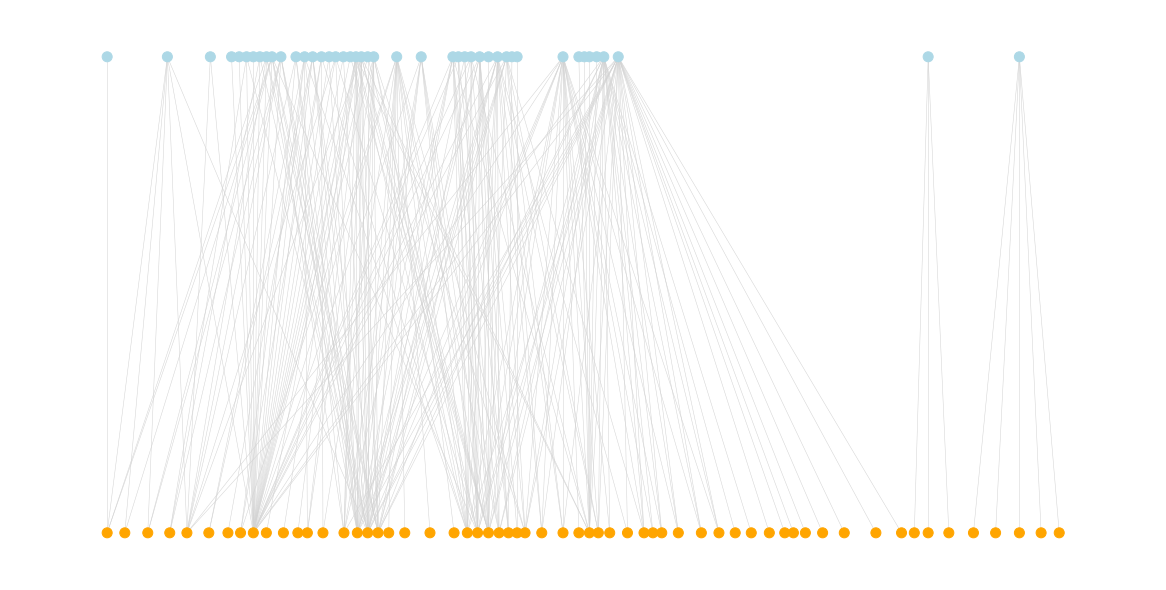

In [40]:
plt.figure(figsize=(16, 8))

pos = nx.nx_agraph.graphviz_layout(g, prog="dot") #"dot", "sfdp", neato
#pos = nx.circular_layout(g)

options = {
    'node_size': 100,
    'width': 0.5,
    'arrows': False,
    'edge_color': "lightgrey"
}
nx.draw(g, node_color=colors, pos=pos, **options)
plt.show()

### Diseases
All reports. Run in browser: https://s.zazuko.com/24fSKE

In [41]:
query = """
SELECT ?diagnosis ?gde ?specie ?stock ?sick ?infected ?killed ?deceased ?epidemics ?death_cause
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:diagnosis-date ?diagnosis;
       disease:animals-stock ?stock;
       disease:animals-sick ?sick;
       disease:animals-infected ?infected;
       disease:animals-killed ?killed;
       disease:animals-deceased ?deceased;
       disease:internet-publication ?date;
       disease:death-cause/schema:name ?death_cause;
       disease:animal-specie/schema:name ?specie;
       schema:containedInPlace/schema:name ?gde .
  
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?death_cause) = "de")
  FILTER (LANG(?specie) = "de")
} 
ORDER BY DESC(?diagnosis) ?gde
"""
df = sparql.send_query(query)
df.head()

,diagnosis,gde,specie,stock,sick,infected,killed,deceased,epidemics,death_cause
0,2021-08-06,Ins,Bienen,1,1,0,0,0,Sauerbrut der Bienen,Klinischer Fall
1,2021-08-04,Gossau (SG),Schlange,1,1,0,0,0,Salmonellose,Anderer Grund
2,2021-08-04,Oberdiessbach,Bienen,1,1,0,0,0,Sauerbrut der Bienen,Klinischer Fall
3,2021-08-03,Adliswil,Schwein,1,1,0,0,0,Enzootische Pneumonie der Schweine,Klinischer Fall
4,2021-08-03,Bonstetten,Bienen,20,3,0,0,0,Sauerbrut der Bienen,Bestandesüberwachung


### Deadly epidemics

Which epidemics lead to death of all animals?

In [42]:
query = """
SELECT ?diagnosis ?gde ?specie ?stock_deceased ?epidemics ?death_cause
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:diagnosis-date ?diagnosis;
       disease:animals-stock ?stock_deceased;
       disease:animals-deceased ?stock_deceased;
       disease:internet-publication ?date;
       disease:death-cause/schema:name ?death_cause;
       disease:animal-specie/schema:name ?specie;
       schema:containedInPlace/schema:name ?gde .
  
  FILTER (?stock_deceased > 1)
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?death_cause) = "de")
  FILTER (LANG(?specie) = "de")
} 
ORDER BY DESC(?stock_deceased)
"""

df = sparql.send_query(query)
df.head()

,diagnosis,gde,specie,stock_deceased,epidemics,death_cause
0,2020-02-27,Wileroltigen,Huhn,24000,Salmonella-Infektion des Geflügels,Bestandesüberwachung
1,2020-12-01,Montanaire,Huhn,4000,Salmonella-Infektion des Geflügels,Untersuchungsprogramm
2,2002-09-10,La Grande Béroche,Kaninchen,300,Virale hämorrhagische Krankheit der Kaninchen,Klinischer Fall
3,1996-02-09,Prangins,Kaninchen,70,Virale hämorrhagische Krankheit der Kaninchen,Klinischer Fall
4,2002-04-03,Bellinzona,Kaninchen,67,Virale hämorrhagische Krankheit der Kaninchen,Klinischer Fall


A disease can be higly contagious. It may be hence sefer to kill all animal stock at certain farm, and prevent potential disease spread.

Which epidemics forced farmers to kill all their stock?

In [43]:
query = """
SELECT ?diagnosis ?gde ?specie ?sick ?infected ?deceased ?stock_killed ?epidemics ?death_cause
WHERE {
  <https://environment.ld.admin.ch/foen/animal-pest/observation/> cube:observation ?obs .
  ?obs disease:epidemics/schema:name ?epidemics;
       disease:diagnosis-date ?diagnosis;
       disease:animals-stock ?stock_killed;
       disease:animals-sick ?sick;
       disease:animals-infected ?infected;
       disease:animals-killed ?stock_killed;
       disease:animals-deceased ?deceased;
       disease:internet-publication ?date;
       disease:death-cause/schema:name ?death_cause;
       disease:animal-specie/schema:name ?specie;
       schema:containedInPlace/schema:name ?gde .
  
  FILTER (?stock_killed > 1)
  FILTER (LANG(?epidemics) = "de")
  FILTER (LANG(?death_cause) = "de")
  FILTER (LANG(?specie) = "de")
} 
ORDER BY DESC(?stock_killed)
"""

df = sparql.send_query(query)
df.head()

,diagnosis,gde,specie,sick,infected,deceased,stock_killed,epidemics,death_cause
0,2014-07-23,Val-de-Travers,Fisch,900,50000,900,90000,Infektiöse Hämatopoietische Nekrose,Ansteckungsverdacht
1,2013-07-01,Cham,Fisch,15000,25000,0,40000,Infektiöse Hämatopoietische Nekrose,Klinischer Fall
2,2004-07-12,Erstfeld,Fisch,0,0,0,30000,Infektiöse Hämatopoietische Nekrose,Klinischer Fall
3,2003-08-12,Courroux,Fisch,0,0,0,16000,Infektiöse Hämatopoietische Nekrose,Klinischer Fall
4,2013-12-31,Agiez,Huhn,0,23,0,16000,Salmonella-Infektion des Geflügels,Bestandesüberwachung
